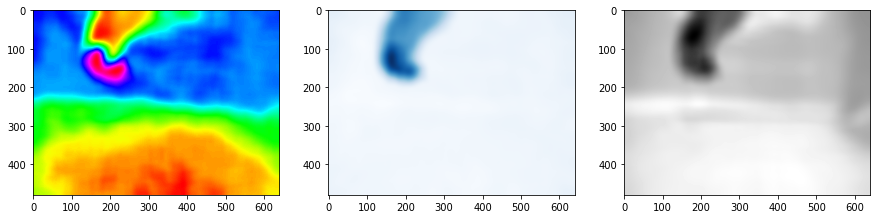

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('baby_turtle.jpg')
img = cv2.resize(img, (640, 480))
imhsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
imhsv = cv2.boxFilter(imhsv, -1, (10, 10)) # Q: what does -1 mean? A: don't output to another array (which is default)

hfilt = cv2.boxFilter(imhsv[:, :, 0], cv2.CV_32F, (40, 40))
sfilt = cv2.boxFilter(imhsv[:, :, 1], cv2.CV_32F, (40, 40))
vfilt = cv2.boxFilter(imhsv[:, :, 2], cv2.CV_32F, (40, 40))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(hfilt, cmap='hsv')
ax[1].imshow(sfilt, cmap='Blues') # Saturation: turtle stands out most
ax[2].imshow(vfilt, cmap='gray')
plt.show()


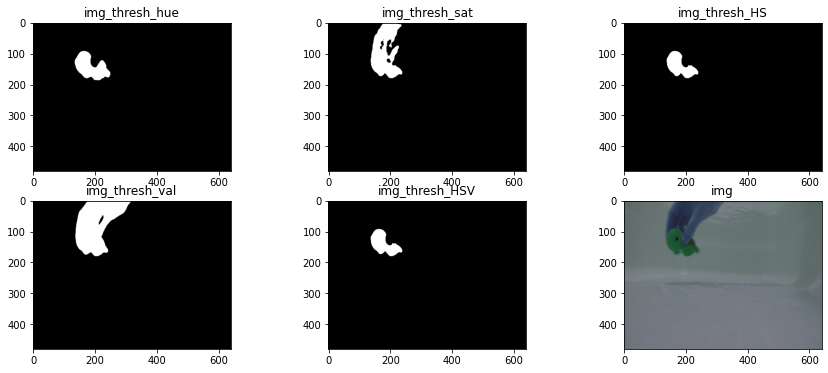

In [2]:
img_thresh_hue = np.logical_and(imhsv[:,:,0] > 35, imhsv[:,:,0] < 255) # technically could multiply arrays
img_thresh_sat = np.logical_and(imhsv[:,:,1] > 110, imhsv[:,:,1] < 200)
img_thresh_HS = np.logical_and(img_thresh_hue, img_thresh_sat)
img_thresh_val = np.logical_and(imhsv[:,:,2] > 40, imhsv[:,:,2] < 100) # not very helpful for detection
img_thresh_HSV = np.logical_and(img_thresh_HS, img_thresh_val)
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
ax[0, 0].imshow(img_thresh_hue, cmap='gray')
ax[0, 0].set_title('img_thresh_hue')
ax[0, 1].imshow(img_thresh_sat, cmap='gray')
ax[0, 1].set_title('img_thresh_sat')
ax[0, 2].imshow(img_thresh_HS, cmap='gray')
ax[0, 2].set_title('img_thresh_HS')
ax[1, 0].imshow(img_thresh_val, cmap='gray')
ax[1, 0].set_title('img_thresh_val')
ax[1, 1].imshow(img_thresh_HSV, cmap='gray')
ax[1, 1].set_title('img_thresh_HSV')
ax[1, 2].imshow(img, cmap='gray')
ax[1, 2].set_title('img')
plt.show()

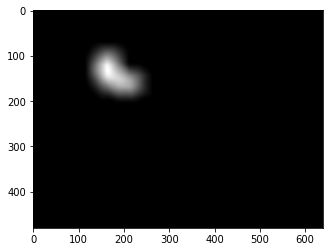

In [3]:
img_filter = cv2.boxFilter(img_thresh_HSV.astype(int), -1, (50,50), normalize=False)
# normalize=False means we add the sum of the neighboring pixels
# Q: Filter size is smaller than the expected size of the turtle in pixel dimensions?
# choose it until it detects turtle clearly
plt.imshow(img_filter, cmap='gray')
plt.show() # The img isn't supposed to appear much different from img_thresh_HSV

[141.93987898 179.49287527]


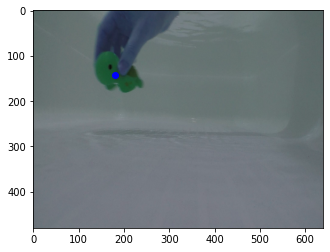

In [50]:
# print(np.unique(img_filter))
thresh = 1000 # Q: How do we choose this threshhold. Manually test.
avg_pixel_pos = np.average((np.argwhere(img_filter>thresh)), axis=0)
print(avg_pixel_pos)

plt.imshow(img)
plt.plot(avg_pixel_pos[1], avg_pixel_pos[0], 'bo')
plt.show()

In [5]:
from calculate_angles import sensor_position, get_angles
get_angles(sensor_position(avg_pixel_pos[0], avg_pixel_pos[1]))

(-28.93725315068111, -21.196751418282638)

In [6]:
img_filter = cv2.boxFilter(img_thresh_HSV.astype(int), -1, (50,50), normalize=False)
img8 = (img_filter * 255 / np.max(img)).astype(np.uint8)
thresh8 = (thresh * 255 / np.max(img)).astype(np.uint8)
thresh8

177

In [44]:
thresh, img_out = cv2.threshold(img8, thresh8, 255, cv2.THRESH_BINARY)
"""The image should now be back to having one of two possible values at each step."""
contours, hierarchy = cv2.findContours(img_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# The return value contours will contain a list of all the contours on the image, where each contour is an np array of pixels along the boundary.

In [49]:
# There was only one contour in the img
for contour in contours:
    print(contour.shape)
    print(np.mean(contour, axis=0))

(400, 1, 2)
[[185.0125 140.2975]]


In [58]:
contours[0].shape

(400, 1, 2)

In [59]:
np.mean(contours[0], axis=0)

array([[185.0125, 140.2975]])

In [60]:
avg_pixel_pos = np.mean(contours[0], axis=0)[0]
avg_pixel_pos

array([185.0125, 140.2975])

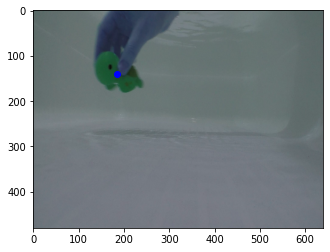

In [61]:
plt.imshow(img)
plt.plot(avg_pixel_pos[0], avg_pixel_pos[1], 'bo')
plt.show()

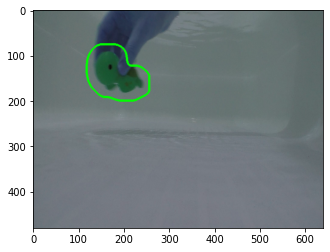

In [62]:
img_contours = cv2.drawContours(img, contours, -1, (0,255,0), 3)
plt.imshow(img_contours, cmap='gray')
plt.show()

In [67]:
"""
contour_size = maximum difference in y and x values along the contour. You could also do a more complex contour integral to obtain the actual size (as projected onto the camera). In either case, you can decide not to return a contour if it is less than a particular size. This will eliminate small “islands” around noise pixels that passed through the initial detector.
"""
contour_x = np.max(contours[0], axis=0)[0][0]
contour_x

256

In [68]:
contour_y = np.max(contours[0], axis=0)[0][1]
contour_y

199

In [70]:
contour_size = contour_x * contour_y
contour_size

50944